In [72]:
!pip install scikit-learn pandas seaborn matplotlib

In [73]:
import os
import pandas as pd

metadata_labels = {
    '# River:': 'river',
    '# Station:': 'station',
    '# Latitude (DD):': 'latitude',
    '# Longitude (DD):': 'longitude',
    '# Catchment area (km≤):': 'catchment_area',
    '# Altitude (m ASL):': 'altitude',
    '# Next downstream station:': 'next_downstream_station',
    '# Remarks:': 'remarks',
    '# Owner of original data:': 'owner_of_original_data',
    '# GRDC-No.:': 'grdc_number',
    '# Unit of measure:': 'unit_of_measure',
}

metadata_df = pd.DataFrame(columns=list(metadata_labels.values()))
flux_data_df = pd.DataFrame()

folder_path = 'data'

# Loop over files in the folder
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)

    metadata = {}
    data_start_row = None
    data = None

    with open(file_path, encoding='latin-1') as file:
        lines = file.readlines()

        # Parse metadata and find start row of the data
        for i, line in enumerate(lines):
            if line.startswith('# Data lines:'):
                data_start_row = i + 2  # Skip two lines after the metadata line
                break

            for key, value in metadata_labels.items():
                if line.startswith(key):
                    metadata[value] = line.split(':')[1].strip()

        # Read the data from the file
        if data_start_row:
            data = pd.read_csv(file_path, delimiter=';', skiprows=data_start_row, encoding='latin-1')
            data.columns = data.columns.str.strip()
            data['GRDC-No.'] = metadata['grdc_number']
            flux_data_df = pd.concat([flux_data_df, data])

    if 'grdc_number' in metadata:
        grdc_number = metadata['grdc_number']
        metadata_df.loc[grdc_number] = metadata

# Set the index of the flux data DataFrame
flux_data_df.set_index(['GRDC-No.', 'YYYY-MM-DD'], inplace=True)

In [74]:
import numpy as np

flux_data_df['Value'] = flux_data_df['Value'].replace(-999.0, np.nan)
flux_data_df = flux_data_df.dropna()

In [75]:
# Convert the 'YYYY-MM-DD' string to datetime
flux_data_df['Date'] = pd.to_datetime(flux_data_df.index.get_level_values(1))

# Extract the levels into separate columns
flux_data_df['GRDC-No.'] = flux_data_df.index.get_level_values(0)
flux_data_df['Year'] = flux_data_df['Date'].dt.year
flux_data_df['Month'] = flux_data_df['Date'].dt.month_name()
flux_data_df['Day'] = flux_data_df['Date'].dt.day

# Rename the index levels if desired
flux_data_df.index.names = ['GRDC-No.', 'Date']

In [76]:
flux_data_df.drop(['Date','GRDC-No.'],axis=1, inplace=True)
flux_data_df.head()

hh:mm  Value  Year     Month  Day
GRDC-No. Date                                         
6335620  1980-11-01  --:--  0.637  1980  November    1
         1980-11-02  --:--  0.571  1980  November    2
         1980-11-03  --:--  0.466  1980  November    3
         1980-11-04  --:--  0.385  1980  November    4
         1980-11-05  --:--  0.402  1980  November    5

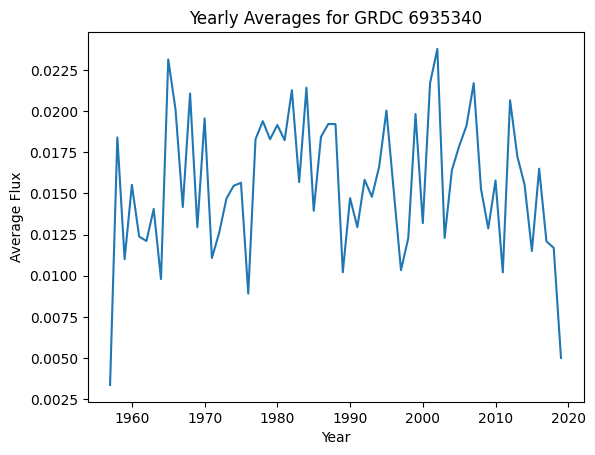

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Convert 'Date' index to datetime format
flux_data_df.index = [flux_data_df.index.get_level_values('GRDC-No.'), pd.to_datetime(flux_data_df.index.get_level_values('Date'))]

# Compute yearly averages for each GRDC-No.
yearly_averages = flux_data_df.groupby([flux_data_df.index.get_level_values('GRDC-No.'), flux_data_df.index.get_level_values('Date').year])['Value'].mean()

# Reset the index to make GRDC-No. and Year as columns
yearly_averages = yearly_averages.reset_index()

# Set the desired GRDC number
grdc_number = '6935340'

# Filter the yearly averages for the specified GRDC number
grdc_yearly_averages = yearly_averages[yearly_averages['GRDC-No.'] == grdc_number]

# Plot the yearly averages for the specified GRDC number using Seaborn
sns.lineplot(x='Date', y='Value', data=grdc_yearly_averages)

# Set the plot title and labels
plt.title(f'Yearly Averages for GRDC {grdc_number}')
plt.xlabel('Year')
plt.ylabel('Average Flux')

# Display the plot
plt.show()


In [78]:
import pandas as pd
from scipy.stats import linregress

# Assuming you have already created the `flux_data_df` dataframe

# Calculate the minimum year for each GRDC
min_year_per_grdc = flux_data_df.groupby('GRDC-No.')['Year'].min()

# Normalize the year values by subtracting the minimum year for each GRDC
flux_data_df['Normalized Year'] = flux_data_df.groupby('GRDC-No.').apply(lambda x: x['Year'] - min_year_per_grdc[x.name]).values

# Calculate the average annual flux for each GRDC and normalized year
avg_flux_per_year = flux_data_df.groupby(['GRDC-No.', 'Normalized Year'])['Value'].mean().reset_index()

# Perform linear regression analysis on the normalized year values
linear_regression_df = avg_flux_per_year.groupby('GRDC-No.').apply(lambda x: linregress(x['Normalized Year'], x['Value']))

# Create a new dataframe for the linear regression results
linear_regression_results = pd.DataFrame(linear_regression_df.tolist(), columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'])
linear_regression_results.index = linear_regression_df.index

# Add the R-squared column to the linear_regression_results dataframe
linear_regression_results['R-squared'] = linear_regression_results['rvalue']**2


In [91]:
print(linear_regression_results.nsmallest(5, 'slope'))
print(linear_regression_results.nlargest(5, 'intercept'))

             slope    intercept    rvalue    pvalue    stderr  R-squared
GRDC-No.                                                                
6335150  -6.618037  2000.689485 -0.264873  0.108034  4.015554   0.070158
6935051  -1.483461  1093.457852 -0.228461  0.067180  0.796440   0.052195
6335070  -1.335975  2086.807318 -0.076982  0.473346  1.855063   0.005926
6435060  -0.864573  2263.743693 -0.063221  0.503977  1.289619   0.003997
6335100  -0.601291  1686.611363 -0.033658  0.807271  2.452543   0.001133
             slope    intercept    rvalue    pvalue    stderr  R-squared
GRDC-No.                                                                
6435060  -0.864573  2263.743693 -0.063221  0.503977  1.289619   0.003997
6335020   0.805507  2225.009262  0.064771  0.524156  1.260047   0.004195
6335070  -1.335975  2086.807318 -0.076982  0.473346  1.855063   0.005926
6335050   1.377078  2064.332414  0.079903  0.530247  2.181775   0.006384
6335060   1.816243  2045.389426  0.127662  0.387203

In [80]:
metadata_df.loc['6935340']

river                                                          SPERBELGRABEN
station                                                                WASEN
latitude                                                             47.0158
longitude                                                             7.8427
catchment_area                                                           NaN
altitude                                                               960.1
next_downstream_station                                              6935302
remarks                                                                     
owner_of_original_data     Switzerland - Federal Office for the Environme...
grdc_number                                                          6935340
unit_of_measure                                                         m³/s
Name: 6935340, dtype: object

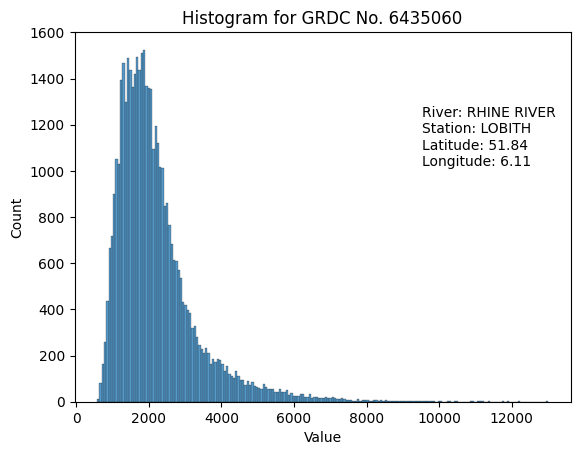

In [97]:
grdc_number = '6435060'
sns.histplot(data=flux_data_df.loc[grdc_number], x='Value')
# Set plot title
plt.title(f"Histogram for GRDC No. {grdc_number}")

# Add metadata to the upper-right part of the plot
metadata = metadata_df.loc[grdc_number]
metadata_text = f"River: {metadata['river']}\nStation: {metadata['station']}\nLatitude: {metadata['latitude']}\nLongitude: {metadata['longitude']}"
plt.text(0.7, 0.8, metadata_text, transform=plt.gca().transAxes, fontsize=10, va='top')

# Display the plot
plt.show()

1.4501017502082955e-07


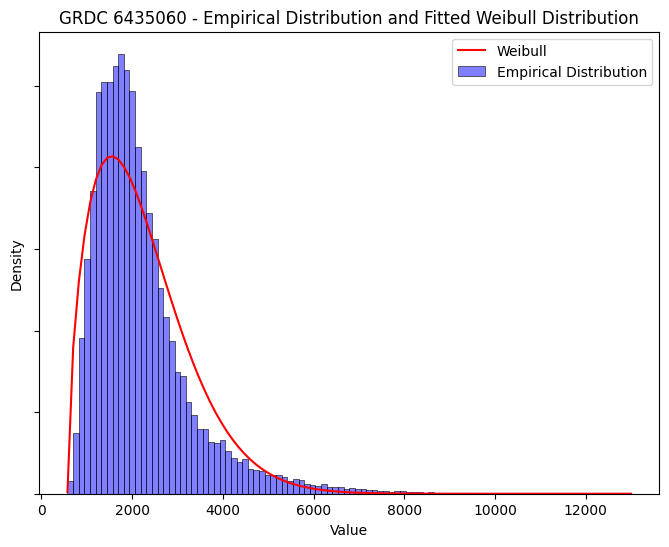

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, gamma, weibull_min
import scipy.integrate as integrate

# Assuming you have the GRDC number and distribution type
grdc_number = '6435060'
distribution_type = 'weibull'
num_bins = 100

# Get the data for the specific GRDC number
grdc_data = flux_data_df.loc[grdc_number, 'Value'].dropna()

# Integrate the histogram
hist, bin_edges = np.histogram(grdc_data, bins=num_bins)
bin_widths = np.diff(bin_edges)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
integral = np.trapz(hist, x=bin_midpoints)

# Fit the chosen distribution to the data
if distribution_type == 'lognorm':
    params = lognorm.fit(grdc_data, floc=0)
    fitted_distribution = lognorm(*params)
    distribution_label = 'Log-Normal'
elif distribution_type == 'gamma':
    params = gamma.fit(grdc_data)
    fitted_distribution = gamma(*params)
    distribution_label = 'Gamma'
elif distribution_type == 'weibull':
    params = weibull_min.fit(grdc_data)
    fitted_distribution = weibull_min(*params)
    distribution_label = 'Weibull'

# Plot the histogram of the empirical data and the fitted distribution
plt.figure(figsize=(8, 6))
plot = sns.histplot(grdc_data, kde=False, stat='density', color='blue', alpha=0.5, bins=num_bins, label='Empirical Distribution')
plot.set_yticklabels([])
x = np.linspace(grdc_data.min(), grdc_data.max(), 100)
plt.plot(x, fitted_distribution.pdf(x), color='red', label=distribution_label)
plt.xlabel('Value')
#plt.ylabel('Normalized Frequency')
plt.title(f'GRDC {grdc_number} - Empirical Distribution and Fitted {distribution_label} Distribution')

tot = 0.0
for a, b in zip(hist, fitted_distribution.pdf(x)):
    tot += (a / integral - b) ** 2
print (tot)

plt.legend()
plt.show()


In [146]:
import numpy as np
from scipy.stats import lognorm, gamma, weibull_min
import scipy.integrate as integrate

num_bins = 100
fit_df = pd.DataFrame(columns=['GRDC-No.','lognormal','gamma','weibull'])

fit_data = []
for grdc_number in flux_data_df.index.get_level_values('GRDC-No.').unique():

    # Get the data for the specific GRDC number
    grdc_data = flux_data_df.loc[grdc_number, 'Value'].dropna()
    grdc_data = grdc_data.replace(0.0, 0.1)

    # Integrate the histogram
    hist, bin_edges = np.histogram(grdc_data, bins=num_bins)
    bin_widths = np.diff(bin_edges)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    integral = np.trapz(hist, x=bin_midpoints)

    # Fit the chosen distribution to the data
    params = lognorm.fit(grdc_data, floc=0)
    fitted_distribution_lognorm = lognorm(*params)
    
    params = gamma.fit(grdc_data)
    fitted_distribution_gamma = gamma(*params)

    params = weibull_min.fit(grdc_data)
    fitted_distribution_weibull = weibull_min(*params)

    # Make fitted data sample
    x = np.linspace(grdc_data.min(), grdc_data.max(), 100)

    tot_lognorm = 0.0
    for a, b in zip(hist, fitted_distribution_lognorm.pdf(x)):
        tot_lognorm += (a / integral - b) ** 2
    tot_gamma = 0.0
    for a, b in zip(hist, fitted_distribution_gamma.pdf(x)):
        tot_gamma += (a / integral - b) ** 2
    tot_weibull = 0.0
    for a, b in zip(hist, fitted_distribution_weibull.pdf(x)):
        tot_weibull += (a / integral - b) ** 2
        
    fit_df.loc[len(fit_df)] = [grdc_number, tot_lognorm, tot_gamma, tot_weibull]
    print (len(fit_df))

print (fit_df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
    GRDC-No.     lognormal         gamma       weibull
0    6335620  3.230245e-01  1.164765e+28  7.041667e+11
1    6335060  3.912480e-08  5.385055e-07  2.455973e-07
2    6335800  1.858757e-04  2.834447e-04  3.724737e+00
3    6935460  6.638761e-02  2.175552e+23  9.649707e-02
4    6935530  2.543454e-02  2.719183e+02  1.645886e+0